# Research on Air Quality in China

Three main data sources in this project
* http://aqi.cga.harvard.edu/china/cumulative/.This data includes air pollutant concentration
of most of the cities in China through Feb. 2014 to Feb. 2016. There are 2542745 records
in it. Important variables include ‘stationname-str’, ‘latitude-float’, ‘longitude-float’,
‘pm25-str’, ‘pm10-str’, ‘o3-str’, ‘no2-str’, ‘so2-str’, ‘co-str’. The last 6 variables represent
the concentration of corresponding pollutant at a specific time

* http://www.stateair.net/web/historical/1/1.html. This data includes hourly PM2.5
concentration in Beijing through Apr. 2008 to July 2017. There are 79559 records in it.
Important variables include ‘Data-str’, ‘Value-float’. Value means the concentration of
PM2.5 in a specific time in Beijing

* http://www.stats.gov.cn/tjgz/wzlj/dftjwz/ This data is provided by Chinese government
and include GDP of each capital city in China from 2013 to 2017. There are 36 records
represent 36 capital cities in total.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.image as mpimg
plt.style.use(['default'])
import cv2

## Data preprocessing

In [53]:
gdp = pd.read_csv('CityGDP.csv')
gdp.dropna(subset=['City'],inplace=True)
aq14_16_or = pd.read_csv('aqi_hourly_to_2016-02-04.csv')
columns = aq14_16_or.columns
aq14_16_or.chinesename.replace('天津南京路','天津',inplace=True)


D:\Program\Anaconda\envs\py36\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (6,7,8,9,10,11,12,13,15,16) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [54]:
aq14_16_or.head(3)

,rowid,locationid,stationname,chinesename,latitude,longitude,pm25,pm10,o3,no2,so2,co,temperature,dewpoint,pressure,humidity,wind,est_time,unix_time
0,120250,522,"Chengbei water plant, Huzhou",湖州市城北水厂,30.891155,120.096593,134,81,31,20,15,14,20,10,1016.0,52,13,20140324110000,1395658800
1,120251,523,"Jishan new village, Huzhou",湖州市吉山新村,30.859939,120.120168,158,83,47,34,14,10,19,11,1016.0,60,9,20140324110000,1395658800
2,120252,524,"Town west water plant, Huzhou",湖州市城西水厂,30.862371,120.084577,147,100,39,31,11,9,19,11,1016.0,60,9,20140324110000,1395658800


In [55]:
aq14_16 = aq14_16_or.copy()
aq14_16.dropna(inplace=True, subset=['stationname','chinesename'],how='all')
aq14_16.stationname = aq14_16.stationname.str.split(',',expand = True)[1].str.strip()
aq14_16['newname'] =  aq14_16.stationname
aq14_16['GDP2013'] = aq14_16['GDP2014'] = aq14_16['GDP2015'] = aq14_16['GDP2016'] = aq14_16['GDP2017'] = np.nan
for i in range(gdp.shape[0]):
    a = gdp.iloc[i,:]
#     print(list(a[['City','2013','2014','2015','2016','2017']]))
    aq14_16['newname'].where(~aq14_16.chinesename.str.contains(a['City(Chinese)'],na=False),a['City'],inplace=True)
aq14_16
aq14_16.dropna(inplace=True, subset=['newname'],how='all')
aq14_16.replace('-',np.nan,inplace=True)
aq14_16.dropna(inplace=True, subset=['pm25','pm10','o3','no2','so2','co'],how='all')
aq14_16[['pm25','pm10','o3','no2','so2','co']] = aq14_16[['pm25','pm10','o3','no2','so2','co']].astype(float)


In [56]:
df_14_16 = aq14_16.groupby('newname')[columns[4:-2]].mean().reset_index()
df_14_16 = df_14_16.set_index('newname').join(gdp.set_index('City'))
df_14_16.drop(['City(Chinese)'],axis=1,inplace=True)
dfcol = df_14_16.columns

## GDP VS AQI

D:\Program\Anaconda\envs\py36\lib\site-packages\numpy\lib\histograms.py:754: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
D:\Program\Anaconda\envs\py36\lib\site-packages\numpy\lib\histograms.py:755: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


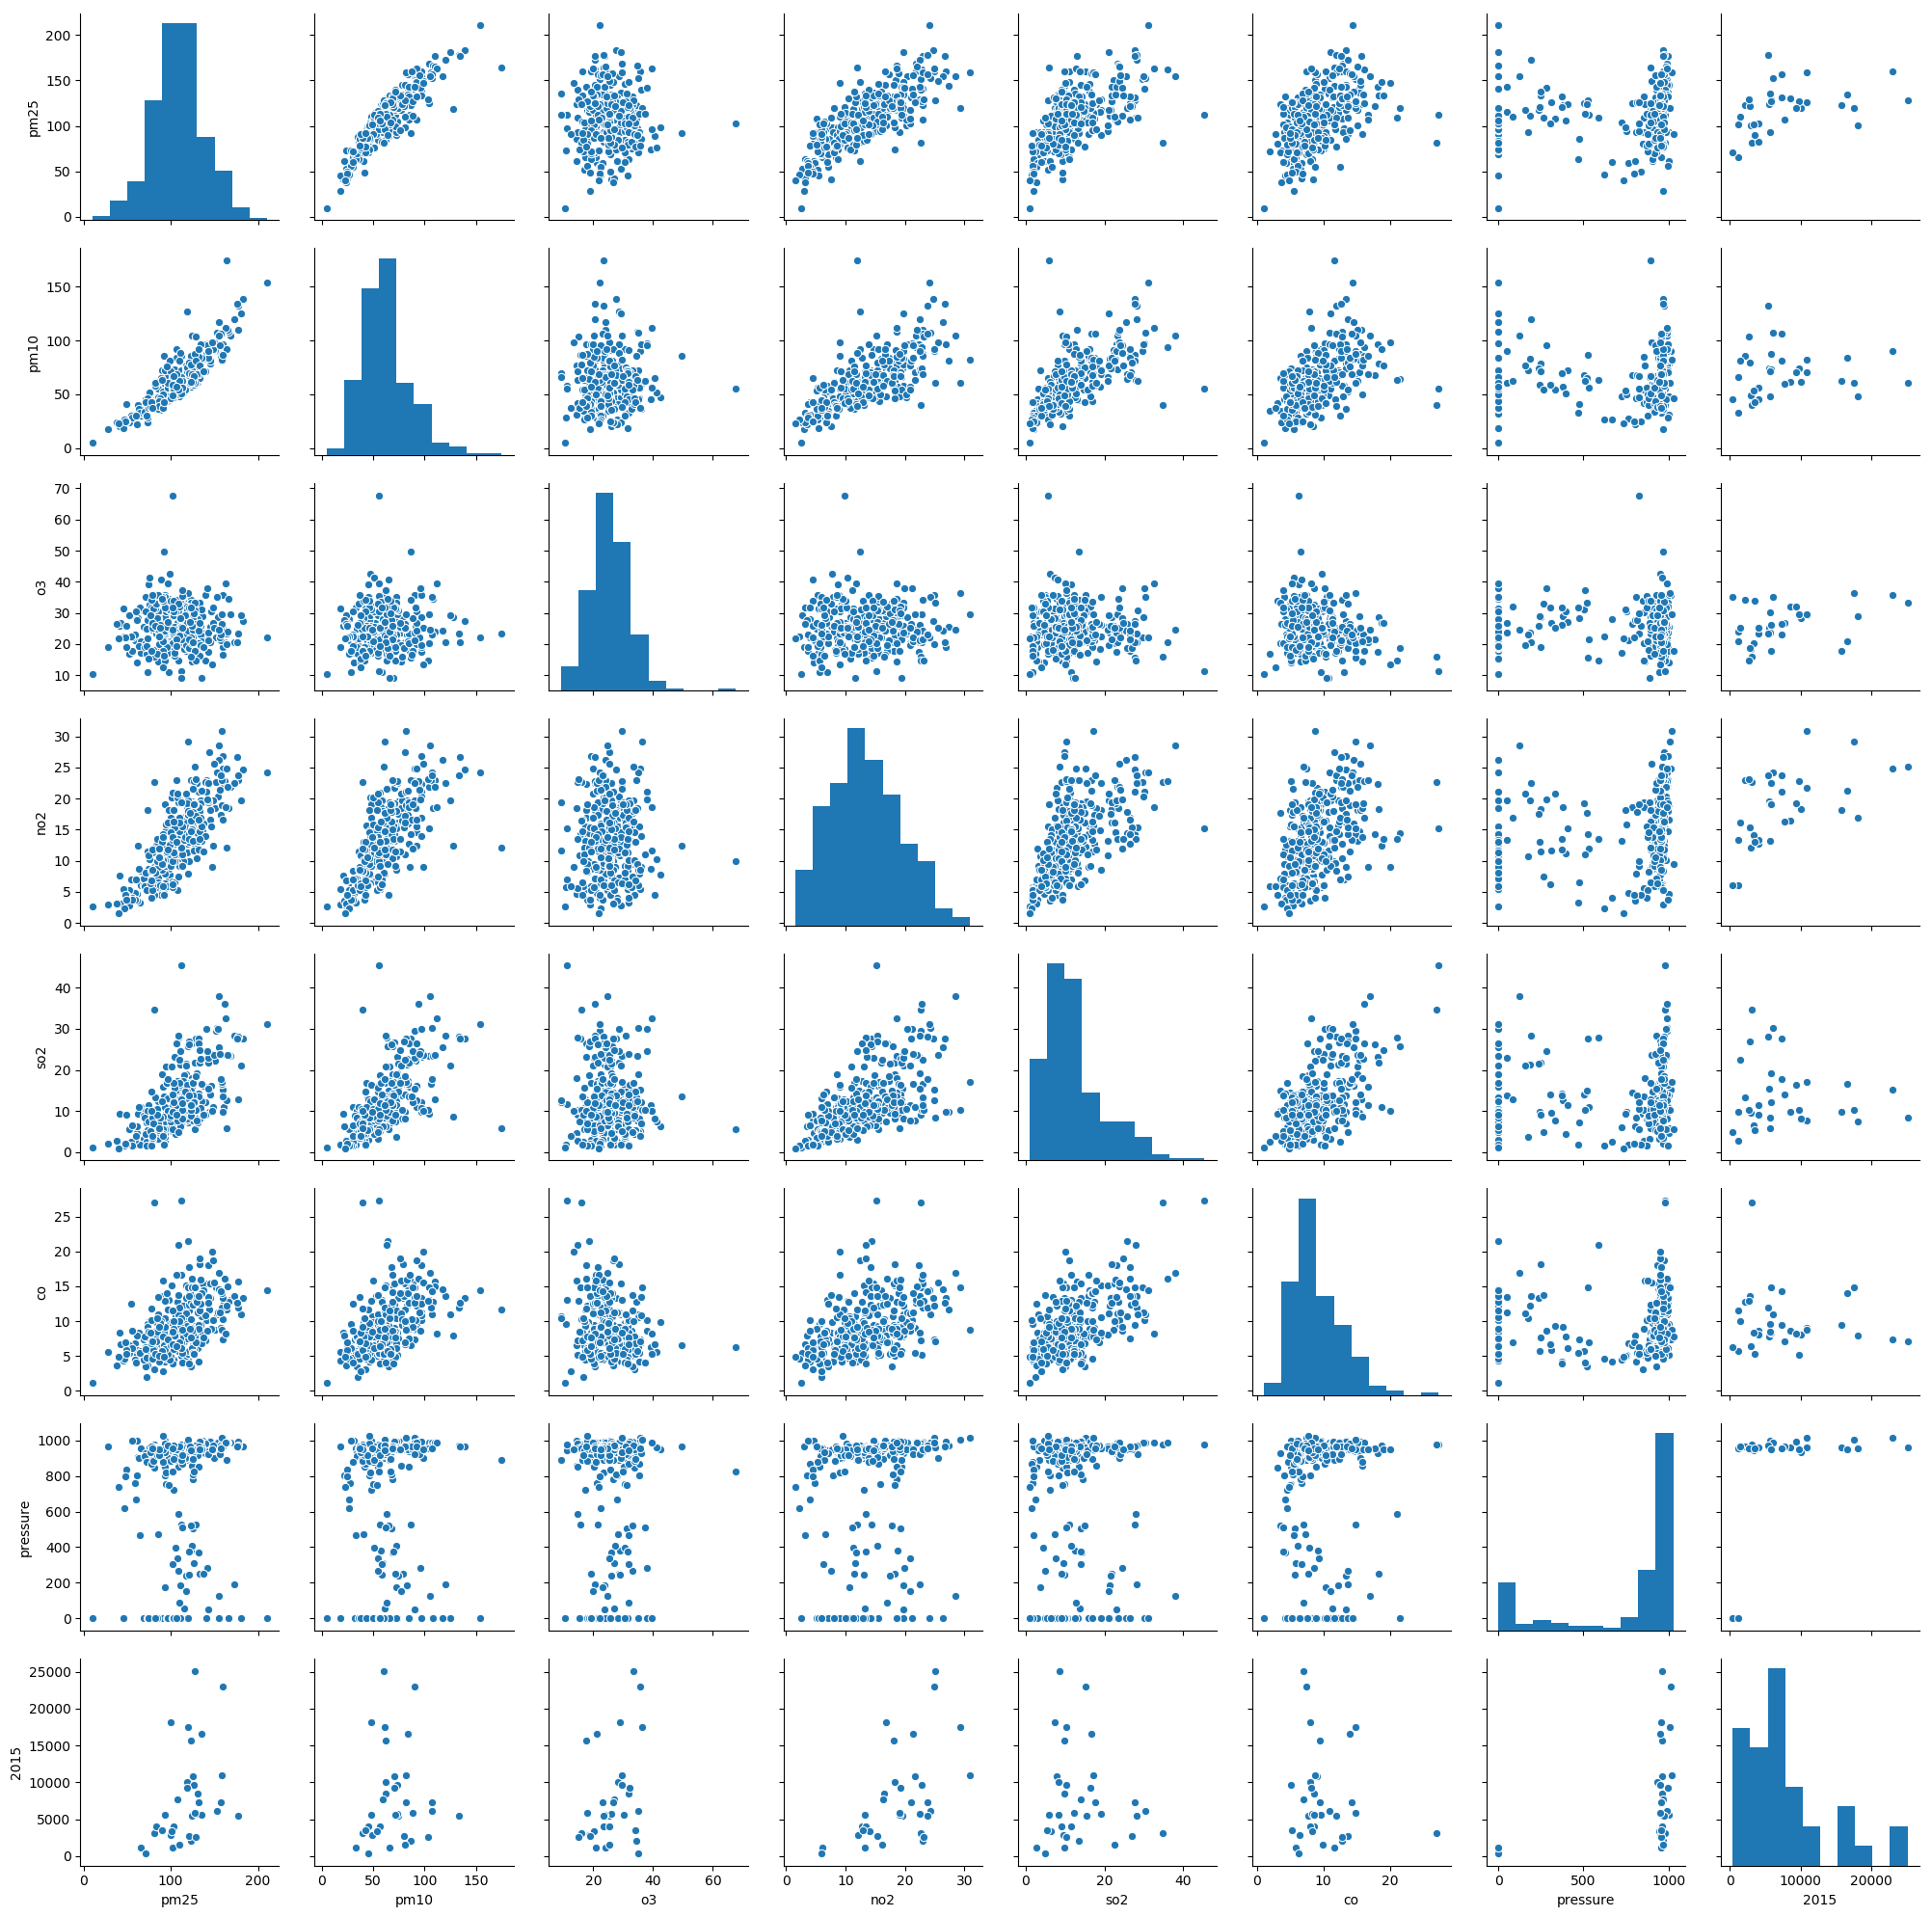

In [57]:
tem = df_14_16[['pm25', 'pm10', 'o3', 'no2', 'so2', 'co','pressure', '2015']]
s1 = sns.pairplot(tem)
# s1.fig.suptitle("Pireplot of US")

- From the pairplot we can see that PM2.5 and PM10 are highly linearly related. PM2.5, PM10 also have linear relationship with NO2 and SO2.
- We can see that there is no obvious linear relationship between air pollutant level and GDP.

## Geographically pattern

This is a Chinese Map

![](china-map.jpg)

In the following plots:
- yellow points --> high pollutant level
- blue points --> low pollutant level

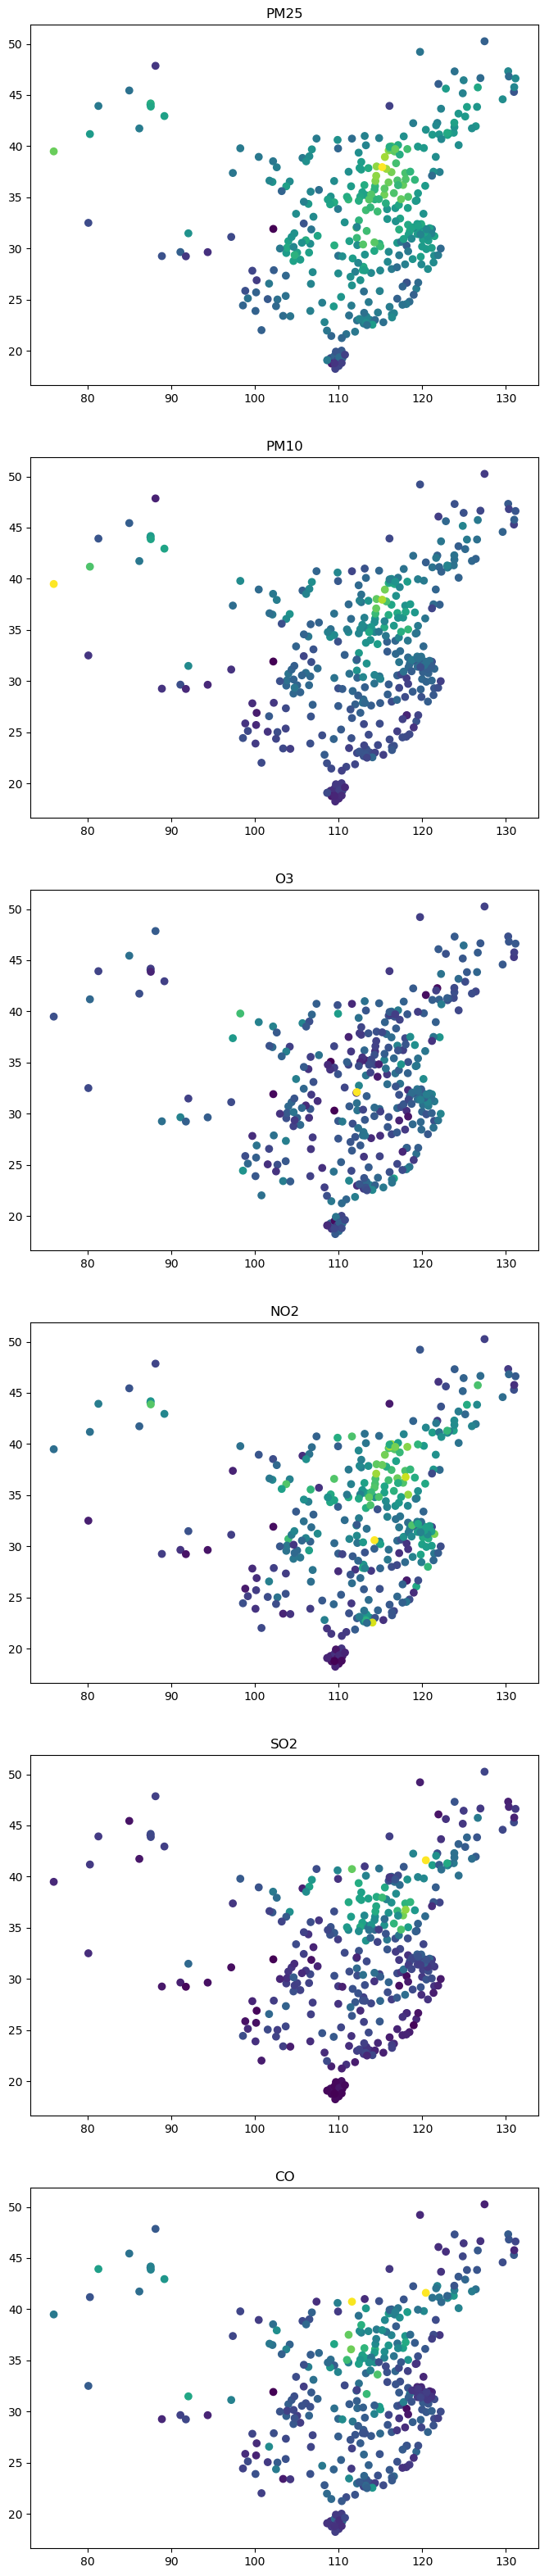

In [58]:
pollutant = ['pm25', 'pm10', 'o3', 'no2', 'so2', 'co']
lat = df_14_16.latitude
lon = df_14_16.longitude
fig, axes = plt.subplots(6,1,figsize=(8,40))
for i in range(len(pollutant)):
    colors = df_14_16[pollutant[i]]
    axes[i].scatter(lon,lat, c=colors)
    axes[i].set_title(pollutant[i].upper())


It is clear that the most polluted point is Beijing. PM2.5 mainly come from incomplete combustion of fossil fuels. 

## Big cities vs Small cities

In [59]:
from scipy import stats

In [60]:
capitalcities = df_14_16[df_14_16.index.isin(gdp.City)]
others = df_14_16[~df_14_16.index.isin(gdp.City)]

In [61]:
stats.ttest_ind(capitalcities["pm25"],others["pm25"],equal_var=False)

Ttest_indResult(statistic=2.5398707079808545, pvalue=0.014542338475058512)

D:\Program\Anaconda\envs\py36\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Text(0.5, 1.0, 'Other cities')

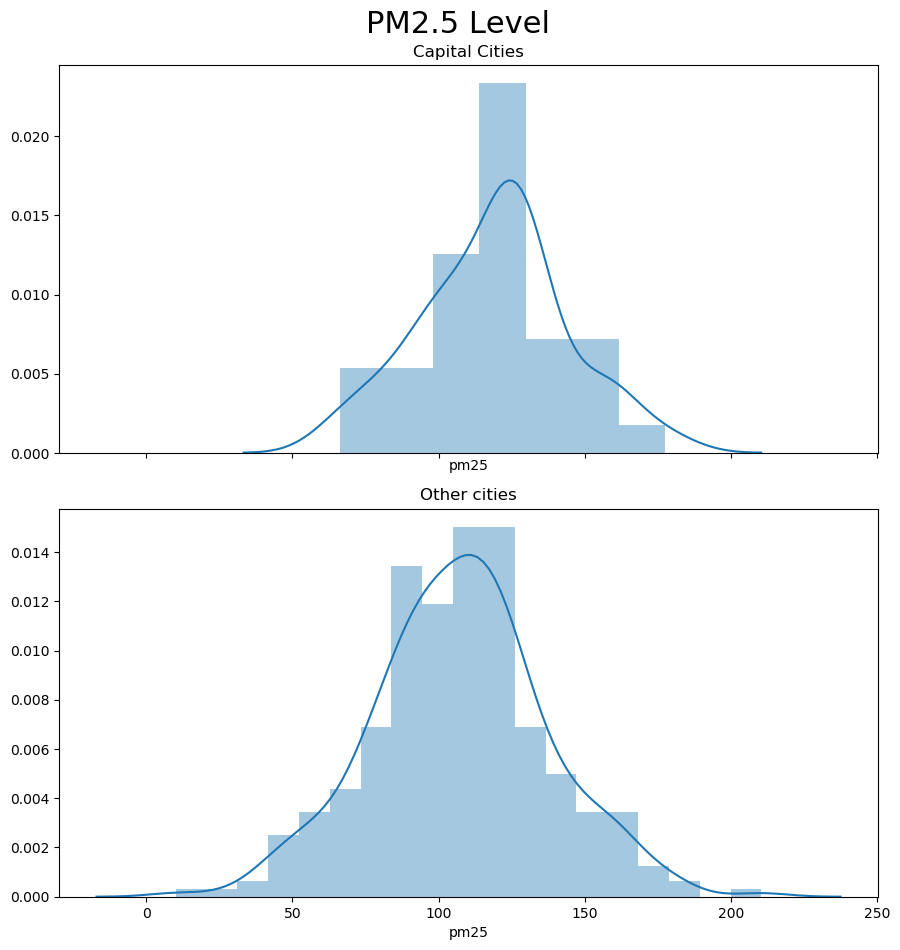

In [62]:
fig, axs = plt.subplots(2,1, figsize=(10,10), sharex=True)
plt.tight_layout(pad=5, w_pad=0.2, h_pad=3)
fig.suptitle("PM2.5 Level",fontsize=22)
sns.distplot(capitalcities.pm25, ax=axs[0]).set_title('Capital Cities')
sns.distplot(others.pm25, ax=axs[1]).set_title('Other cities')

In [63]:
stats.ttest_ind(capitalcities["pm10"],others["pm10"],equal_var=False)

Ttest_indResult(statistic=2.2912467830168985, pvalue=0.02680774020355163)

Text(0.5, 1.0, 'Other cities')

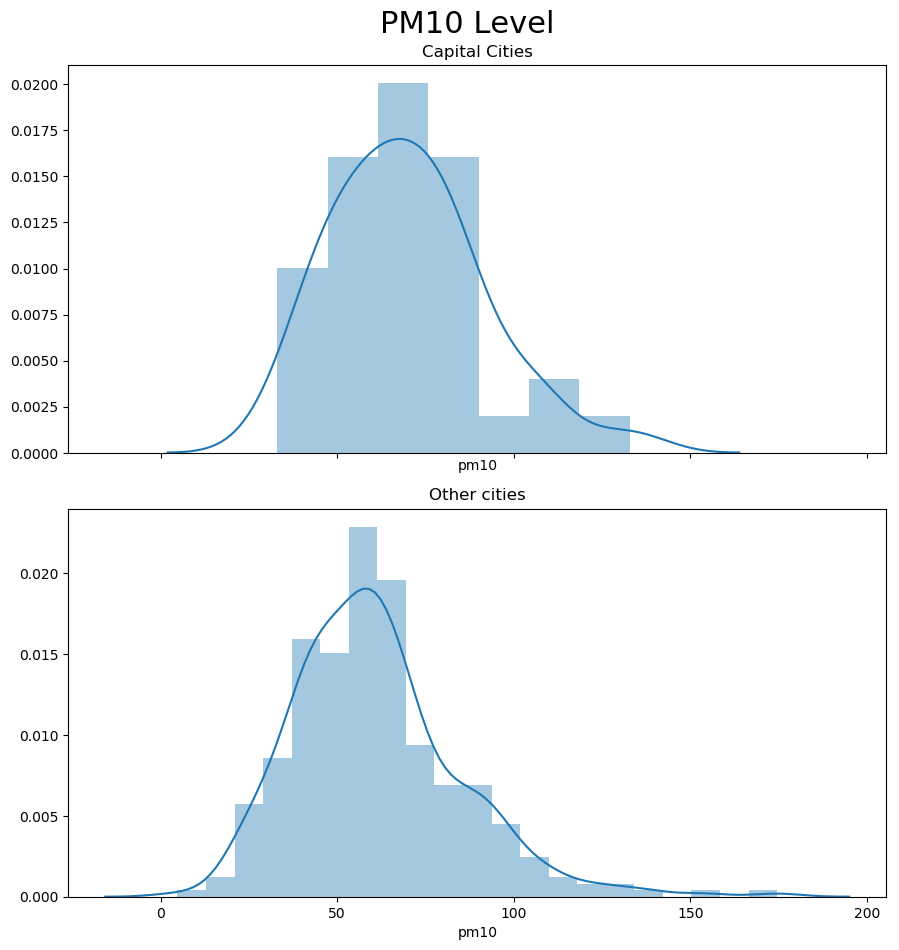

In [64]:
fig, axs = plt.subplots(2,1, figsize=(10,10), sharex=True)
plt.tight_layout(pad=5, w_pad=0.2, h_pad=3)
fig.suptitle("PM10 Level",fontsize=22)
sns.distplot(capitalcities.pm10, ax=axs[0]).set_title('Capital Cities')
sns.distplot(others.pm10, ax=axs[1]).set_title('Other cities')

Text(0.5, 1.0, 'Other cities')

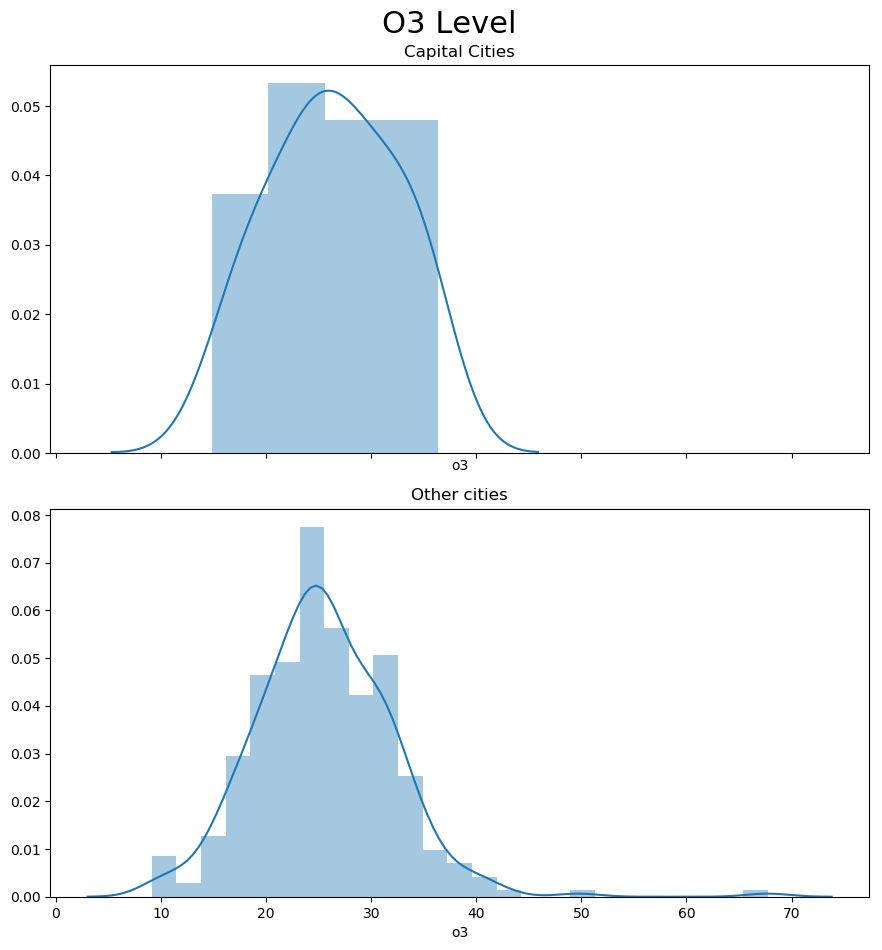

In [65]:
fig, axs = plt.subplots(2,1, figsize=(10,10), sharex=True)
plt.tight_layout(pad=5, w_pad=0.2, h_pad=3)
fig.suptitle("O3 Level",fontsize=22)
sns.distplot(capitalcities.o3, ax=axs[0]).set_title('Capital Cities')
sns.distplot(others.o3, ax=axs[1]).set_title('Other cities')

In [66]:
stats.ttest_ind(capitalcities["no2"],others["no2"],equal_var=False)

Ttest_indResult(statistic=5.890071076449978, pvalue=5.748347645668066e-07)

Text(0.5, 1.0, 'Other cities')

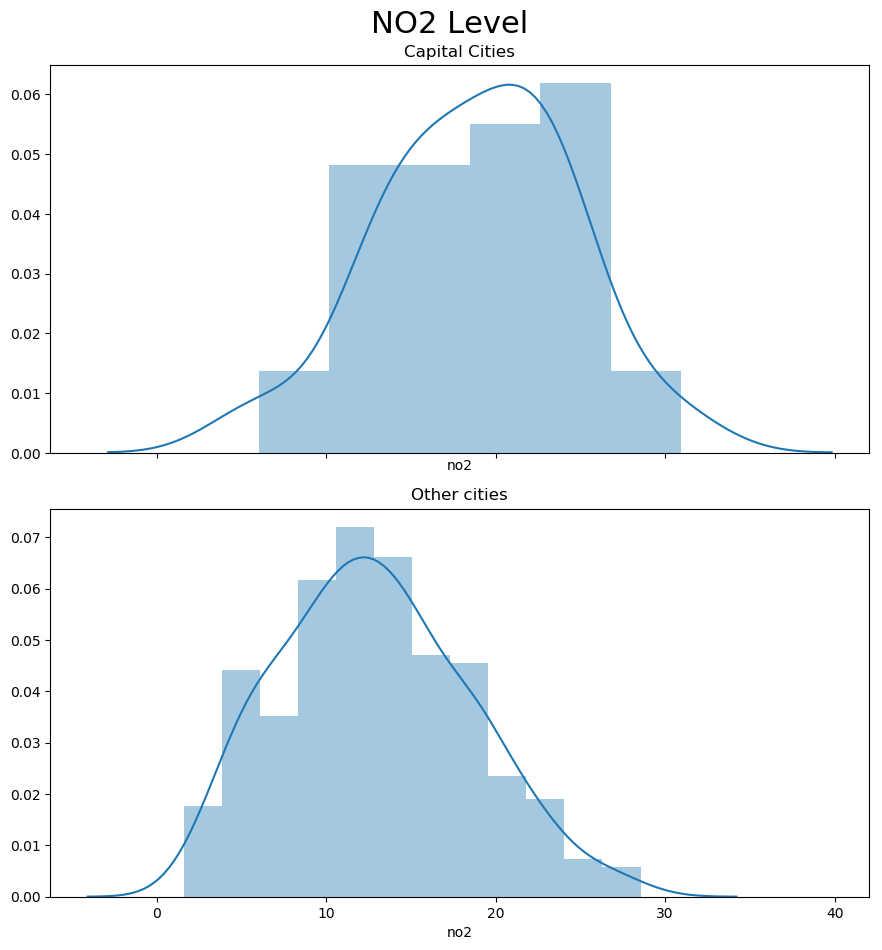

In [67]:
fig, axs = plt.subplots(2,1, figsize=(10,10), sharex=True)
plt.tight_layout(pad=5, w_pad=0.2, h_pad=3)
fig.suptitle("NO2 Level",fontsize=22)
sns.distplot(capitalcities.no2, ax=axs[0]).set_title('Capital Cities')
sns.distplot(others.no2, ax=axs[1]).set_title('Other cities')

In [68]:
stats.ttest_ind(capitalcities["so2"],others["so2"],equal_var=False)

Ttest_indResult(statistic=1.3101181680797593, pvalue=0.19741366584202058)

Text(0.5, 1.0, 'Other cities')

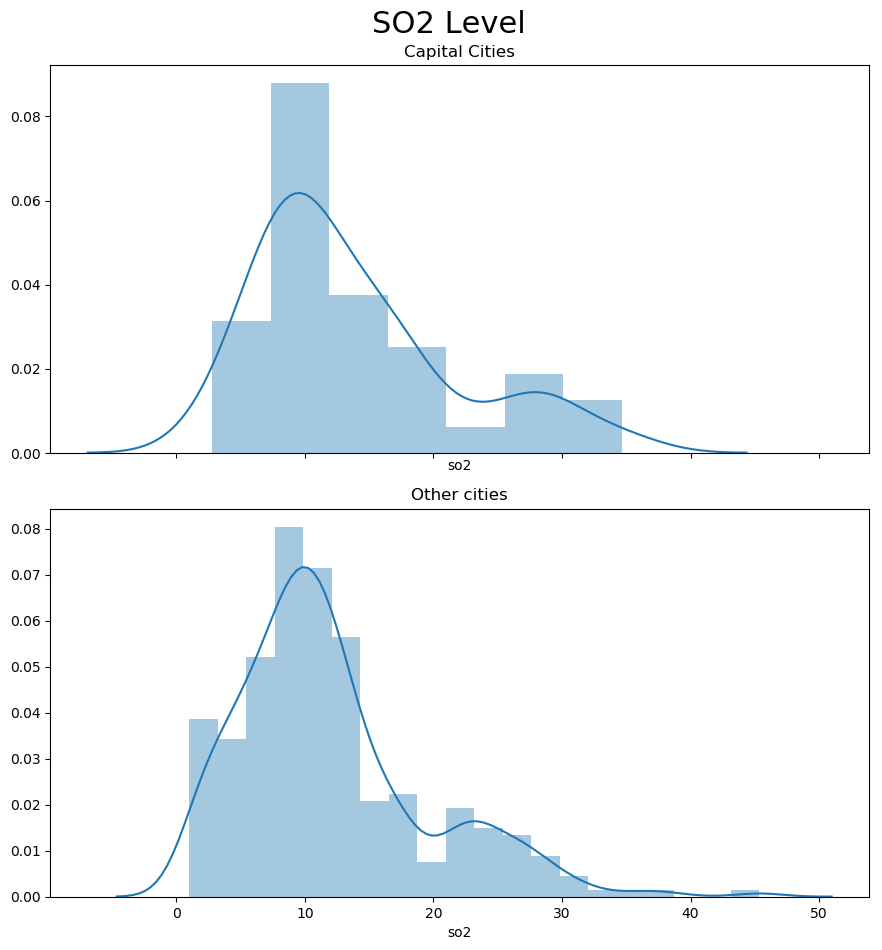

In [69]:
fig, axs = plt.subplots(2,1, figsize=(10,10), sharex=True)
plt.tight_layout(pad=5, w_pad=0.2, h_pad=3)
fig.suptitle("SO2 Level",fontsize=22)
sns.distplot(capitalcities.so2, ax=axs[0]).set_title('Capital Cities')
sns.distplot(others.so2, ax=axs[1]).set_title('Other cities')

In [70]:
stats.ttest_ind(capitalcities["co"],others["co"],equal_var=False)

Ttest_indResult(statistic=1.2462057199515693, pvalue=0.219727583346329)

Text(0.5, 1.0, 'Other cities')

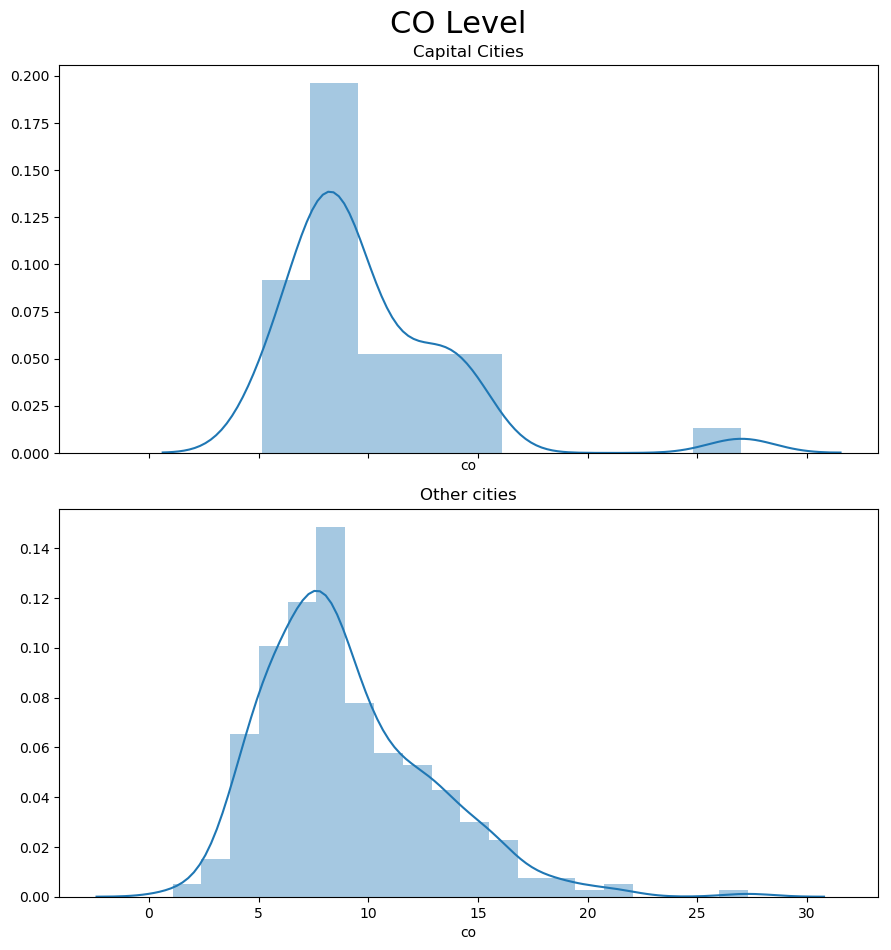

In [71]:
fig, axs = plt.subplots(2,1, figsize=(10,10), sharex=True)
plt.tight_layout(pad=5, w_pad=0.2, h_pad=3)
fig.suptitle("CO Level",fontsize=22)
sns.distplot(capitalcities.co, ax=axs[0]).set_title('Capital Cities')
sns.distplot(others.co, ax=axs[1]).set_title('Other cities')

From both distribution plots and result of T-test, discrepancy of mean pollutant level between capital cities and other cities is ranked in descent order as: NO2 > PM2.5 > PM10 > SO2 > CO > O3

## AQI curve by time

In [72]:
B17 = pd.read_csv('Beijing2017.csv')
B16 = pd.read_csv('Beijing2016.csv')
B15 = pd.read_csv('Beijing2015.csv')
B14 = pd.read_csv('Beijing2014.csv')
B13 = pd.read_csv('Beijing2013.csv')
B12 = pd.read_csv('Beijing2012.csv')
B11 = pd.read_csv('Beijing2011.csv')
B10 = pd.read_csv('Beijing2010.csv')
B09 = pd.read_csv('Beijing2009.csv')
B08 = pd.read_csv('Beijing2008.csv')
frames = [B17, B16, B15, B14,B13, B12,B11, B10,B09, B08]
bj = pd.concat(frames)
bj = bj[bj.Duration=='Valid']
bj['Data'] = pd.to_datetime(bj['Date (LST)'])
bj.drop(['Site','Date (LST)','Parameter','Unit','Duration','QC Name'],axis=1,inplace=True)
bj = bj.sort_values('Data')

In [73]:
bj.head(3)

,Year,Month,Day,Hour,Value,Data
0,2008,4,8,15,207,2008-04-08 15:00:00
1,2008,4,8,16,180,2008-04-08 16:00:00
2,2008,4,8,17,152,2008-04-08 17:00:00


### Average PM2.5 level for each month in a whole year

Text(0, 0.5, 'Concentration')

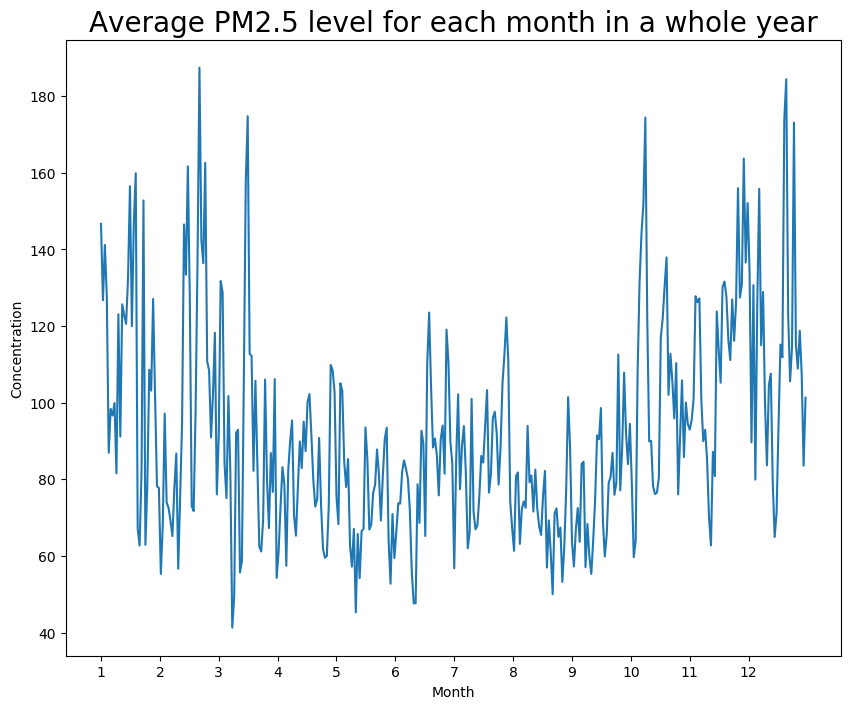

In [74]:
year_month_day = bj.groupby(['Month','Day']).Value.mean()
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,year_month_day.shape[0]),year_month_day)
plt.xticks(np.linspace(0,year_month_day.shape[0],13)[:12],np.arange(1,13))
plt.title("Average PM2.5 level for each month in a whole year",fontsize=20)
plt.xlabel('Month')
plt.ylabel('Concentration')

### Mounthly average PM2.5 level from 2008 to 2017

Text(0.5, 1.0, 'Mounthly average PM2.5 level from 2008 to 2017')

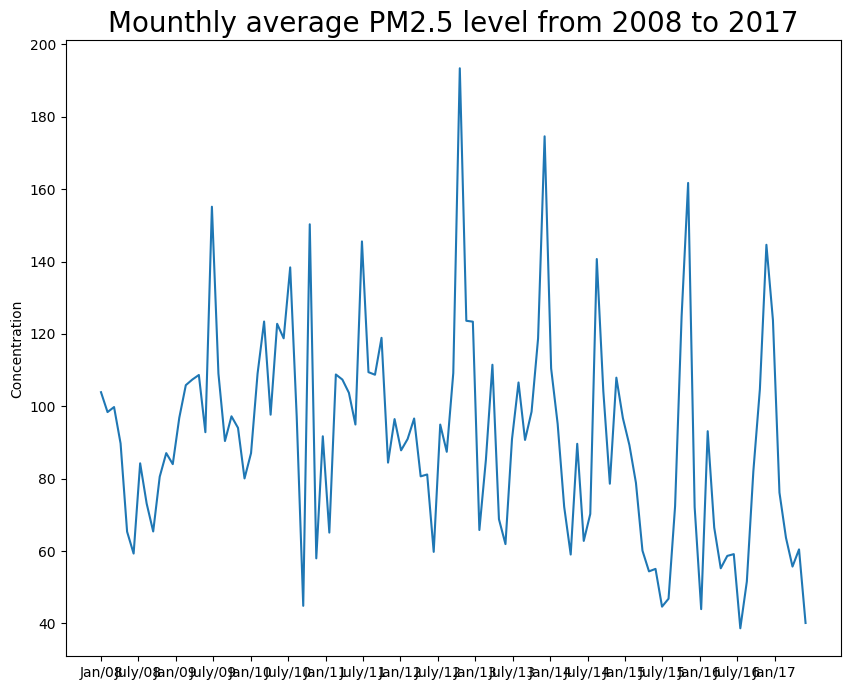

In [75]:
ticks = ['Jan/08','July/08','Jan/09','July/09','Jan/10','July/10','Jan/11','July/11','Jan/12','July/12',
         'Jan/13','July/13','Jan/14','July/14','Jan/15','July/15','Jan/16','July/16','Jan/17']
year_month = bj.groupby(['Year','Month']).Value.mean()
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,year_month.shape[0]),year_month)
plt.xticks(np.linspace(0,year_month.shape[0],20)[:19],ticks)
plt.ylabel('Concentration')
plt.title("Mounthly average PM2.5 level from 2008 to 2017",fontsize=20)

### Hourly average PM2.5 level in a whole day

Text(0, 0.5, 'Concentration')

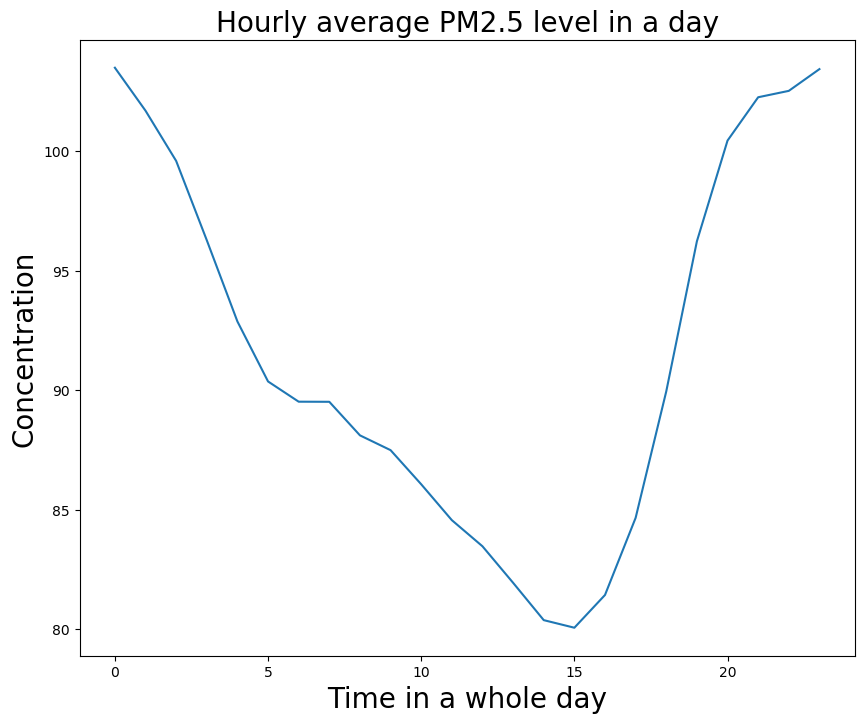

In [76]:
day = bj.groupby("Hour").Value.mean()
plt.figure(figsize=(10,8))
plt.plot(np.arange(0,24),day)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.title("Hourly average PM2.5 level in a day",fontsize=20)
plt.xlabel('Time in a whole day', fontsize=20)
plt.ylabel('Concentration',fontsize=20)

### PM2.5 level change generally from 2008 to 2017

In [77]:
# y = np.convolve(bj.Value, np.ones((10,))/10, mode='valid')
# plt.figure(figsize=(20,10))
# plt.plot(np.arange(len(y)),y)

In [78]:
year_month = bj.groupby(['Year','Month']).Value.mean()
year_month = year_month.reset_index().reset_index()
ticks = year_month.groupby('Year').index.min()

Text(0.5, 1.0, 'Regression plot for mounthly Concentration from 2008 to 2017')

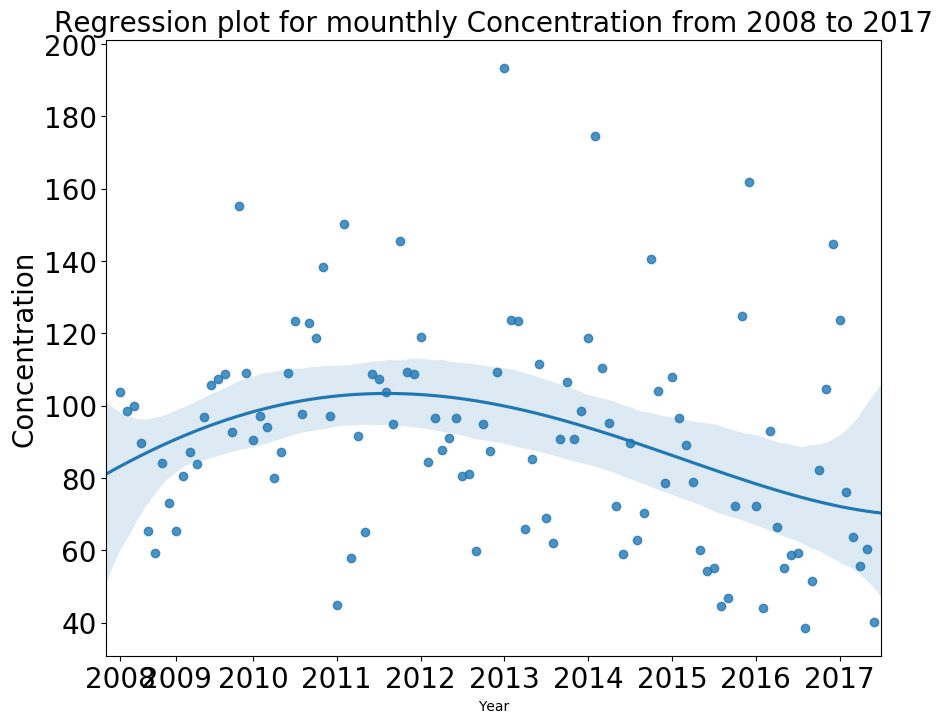

In [79]:
f, ax = plt.subplots(figsize=(10,8))
ax.set(xlim=(-2, year_month.shape[0]))
sns.regplot(x='index', y="Value", data=year_month, order=4)#, scatter=False,truncate=True
plt.xticks(ticks,ticks.index)
plt.rc('xtick', labelsize=20) 
plt.rc('ytick', labelsize=20) 
plt.xlabel('Year')
plt.ylabel('Concentration',fontsize=20)
plt.title("Regression plot for mounthly Concentration from 2008 to 2017",fontsize=20)